# Classifying multi-label comments with Logistic Regression
#### Rhodium Beng
Started on 20 December 2017

This kernel is inspired by:
- kernel by Jeremy Howard : _NB-SVM strong linear baseline + EDA (0.052 lb)_
- kernel by Issac : _logistic regression (0.055 lb)_
- _Solving Multi-Label Classification problems_, https://www.analyticsvidhya.com/blog/2017/08/introduction-to-multi-label-classification/

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import re

C:\Users\amakr\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Load training and test data

In [2]:
train_df = pd.read_csv('../Translated/cleaned/train.csv')
test_df = pd.read_csv('../Translated/cleaned/test.csv')

## Examine the data (EDA)

In [3]:
train_df.sample(5)

,ID,Text,Label
1214,ID_tBlVTsLf,Atumiki a Dayosizi ya Dedza Asulidwa za Chibal...,RELIGION
76,ID_DQZTUqjC,Papa Alalika za Kulolerana Wolemba: Thokozani ...,SOCIAL
530,ID_TfrZKjLJ,Ku Machinga akonzekera ulimi wa fodya Alimi a...,FARMING
1006,ID_lqJVcryZ,Gondwe azaza pamsonkhano Nduna ya za chuma Go...,POLITICS
813,ID_drZICSvK,Bungwe La Amayi Ku Mphakati Wa St. Clara Lalim...,RELIGION


In the training data, the comments are labelled as one or more of the six categories; toxic, severe toxic, obscene, threat, insult and identity hate. This is essentially a multi-label classification problem.

In [4]:
cols_target = train_df.Label.unique().tolist()

In [5]:
# check missing values in numeric columns
train_df.describe()

,ID,Text,Label
count,1436,1436,1436
unique,1436,1436,20
top,ID_mGNngPhu,Chimanga chikololedwa chochepaUnduna Kauniuni...,POLITICS
freq,1,1,279


There are no missing numeric values. 
As the mean values are very small (some way below 0.05), there would be many not labelled as positive in the six categories. From this I guess that there would be many comments which are not labelled in any of the six categories. Let's take a look.

In [6]:
# unlabelled_in_all = train_df[(train_df['toxic']!=1) & (train_df['severe_toxic']!=1) & (train_df['obscene']!=1) & 
#                             (train_df['threat']!=1) & (train_df['insult']!=1) & (train_df['identity_hate']!=1)]
# print('Percentage of unlabelled comments is ', len(unlabelled_in_all)/len(train_df)*100)

from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
y_train = lb.fit_transform(train_df['Label'])

y_train = pd.DataFrame(y_train, columns= lb.classes_)
y_train

train_df = pd.concat([train_df, y_train], axis = 1)
train_df

,ID,Text,Label,ARTS AND CRAFTS,CULTURE,ECONOMY,EDUCATION,FARMING,FLOODING,HEALTH,...,OPINION/ESSAY,POLITICS,RELATIONSHIPS,RELIGION,SOCIAL,SOCIAL ISSUES,SPORTS,TRANSPORT,WILDLIFE/ENVIRONMENT,WITCHCRAFT
0,ID_AASHwXxg,Mwangonde: Khansala wachinyamata Akamati achi...,POLITICS,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,ID_AGoFySzn,MCP siidakhutire ndi kalembera Chipani cha Ma...,POLITICS,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,ID_AGrrkBGP,Bungwe la MANEPO Lapempha Boma Liganizire Anth...,HEALTH,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,ID_AIJeigeG,Ndale zogawanitsa miyambo zanyanya Si zachile...,POLITICS,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,ID_APMprMbV,Nanga wapolisi ataphofomoka? Masiku ano sichi...,LAW/ORDER,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1431,ID_zmTmmEio,Eni Minibus Ati Ali ndi Ufulu Wokweza Mitengo ...,TRANSPORT,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1432,ID_znOlIaGQ,Kachali apepesa: Kulankhula motumbwa kuthe An...,POLITICS,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1433,ID_znracTjN,Mawu supports non-fiction writers The Malawi ...,EDUCATION,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1434,ID_ztdsmmva,Tame Mwawa: Phwete ndiye kudya kwake Sewero l...,SOCIAL ISSUES,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [7]:
# # check for any 'null' comment
# no_comment = train_df[train_df['comment_text'].isnull()]
# len(no_comment)

In [8]:
# test_df.head()

In [9]:
# no_comment = test_df[test_df['comment_text'].isnull()]
# no_comment

All rows in the training and test data contain comments, so there's no need to clean up null fields.

In [10]:
# let's see the total rows in train, test data and the numbers for the various categories
print('Total rows in test is {}'.format(len(test_df)))
print('Total rows in train is {}'.format(len(train_df)))
print(train_df[cols_target].sum())

Total rows in test is 620
Total rows in train is 1436
POLITICS                279
HEALTH                  127
LAW/ORDER               136
RELIGION                147
FARMING                  78
WILDLIFE/ENVIRONMENT     36
SOCIAL ISSUES           134
SOCIAL                  152
OPINION/ESSAY            26
LOCALCHIEFS              25
WITCHCRAFT               16
ECONOMY                  86
SPORTS                   49
RELATIONSHIPS            39
TRANSPORT                11
CULTURE                  23
EDUCATION                43
MUSIC                    15
ARTS AND CRAFTS           7
FLOODING                  7
dtype: int64


As mentioned earlier, majority of the comments in the training data are not labelled in one or more of these categories.

In [11]:
# Let's look at the character length for the rows in the training data and record these
train_df['char_length'] = train_df['Text'].apply(lambda x: len(str(x)))

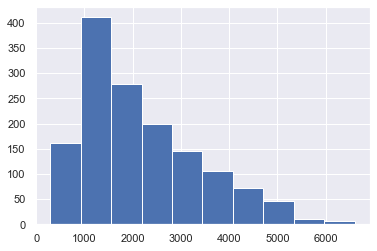

In [12]:
# look at the histogram plot for text length
sns.set()
train_df['char_length'].hist()
plt.show()

Most of the text length are within 500 characters, with some up to 5,000 characters long.

Next, let's examine the correlations among the target variables.

In [13]:
data = train_df[cols_target]

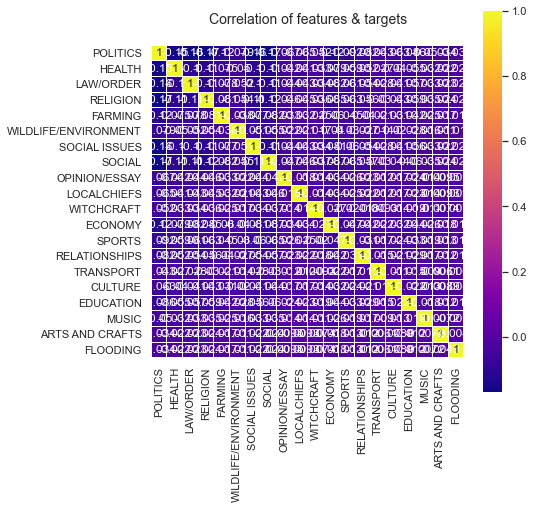

In [14]:
colormap = plt.cm.plasma
plt.figure(figsize=(7,7))
plt.title('Correlation of features & targets',y=1.05,size=14)
sns.heatmap(data.astype(float).corr(),linewidths=0.1,vmax=1.0,square=True,cmap=colormap,
           linecolor='white',annot=True)

Indeed, it looks like some of the labels are higher correlated, e.g. insult-obscene has the highest at 0.74, followed by toxic-obscene and toxic-insult.

What about the character length & distribution of the comment text in the test data?

In [15]:
test_df['char_length'] = test_df['Text'].apply(lambda x: len(str(x)))

In [16]:
data.astype(float).corr()

,POLITICS,HEALTH,LAW/ORDER,RELIGION,FARMING,WILDLIFE/ENVIRONMENT,SOCIAL ISSUES,SOCIAL,OPINION/ESSAY,LOCALCHIEFS,WITCHCRAFT,ECONOMY,SPORTS,RELATIONSHIPS,TRANSPORT,CULTURE,EDUCATION,MUSIC,ARTS AND CRAFTS,FLOODING
POLITICS,1.000000,-0.152956,-0.158830,-0.165832,-0.117688,-0.078745,-0.157537,-0.168956,-0.066683,-0.065364,-0.052126,-0.123942,-0.092299,-0.082048,-0.043144,-0.062651,-0.086277,-0.050453,-0.034369,-0.034369
HEALTH,-0.152956,1.000000,-0.100746,-0.105188,-0.074650,-0.049948,-0.099926,-0.107170,-0.042297,-0.041461,-0.033063,-0.078617,-0.058545,-0.052043,-0.027367,-0.039740,-0.054726,-0.032002,-0.021800,-0.021800
LAW/ORDER,-0.158830,-0.100746,1.000000,-0.109227,-0.077517,-0.051866,-0.103764,-0.111285,-0.043921,-0.043053,-0.034333,-0.081636,-0.060794,-0.054042,-0.028418,-0.041266,-0.056827,-0.033231,-0.022638,-0.022638
RELIGION,-0.165832,-0.105188,-0.109227,1.000000,-0.080934,-0.054153,-0.108338,-0.116191,-0.045857,-0.044951,-0.035847,-0.085234,-0.063473,-0.056424,-0.029670,-0.043085,-0.059332,-0.034696,-0.023636,-0.023636
FARMING,-0.117688,-0.074650,-0.077517,-0.080934,1.000000,-0.038431,-0.076885,-0.082459,-0.032544,-0.031901,-0.025440,-0.060489,-0.045046,-0.040043,-0.021057,-0.030577,-0.042107,-0.024623,-0.016774,-0.016774
WILDLIFE/ENVIRONMENT,-0.078745,-0.049948,-0.051866,-0.054153,-0.038431,1.000000,-0.051444,-0.055173,-0.021775,-0.021345,-0.017022,-0.040473,-0.030140,-0.026793,-0.014089,-0.020459,-0.028174,-0.016475,-0.011223,-0.011223
SOCIAL ISSUES,-0.157537,-0.099926,-0.103764,-0.108338,-0.076885,-0.051444,1.000000,-0.110379,-0.043564,-0.042703,-0.034054,-0.080971,-0.060299,-0.053602,-0.028186,-0.040930,-0.056364,-0.032961,-0.022453,-0.022453
SOCIAL,-0.168956,-0.107170,-0.111285,-0.116191,-0.082459,-0.055173,-0.110379,1.000000,-0.046721,-0.045798,-0.036522,-0.086840,-0.064669,-0.057487,-0.030229,-0.043897,-0.060450,-0.035350,-0.024081,-0.024081
OPINION/ESSAY,-0.066683,-0.042297,-0.043921,-0.045857,-0.032544,-0.021775,-0.043564,-0.046721,1.000000,-0.018075,-0.014414,-0.034274,-0.025523,-0.022689,-0.011931,-0.017325,-0.023858,-0.013952,-0.009504,-0.009504
LOCALCHIEFS,-0.065364,-0.041461,-0.043053,-0.044951,-0.031901,-0.021345,-0.042703,-0.045798,-0.018075,1.000000,-0.014129,-0.033596,-0.025019,-0.022240,-0.011695,-0.016982,-0.023386,-0.013676,-0.009316,-0.009316


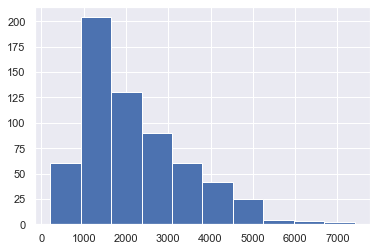

In [17]:
plt.figure()
plt.hist(test_df['char_length'])
plt.show()

Now, the shape of character length distribution looks similar between the training data and the train data. For the training data, I guess the train data were clipped to 5,000 characters to facilitate the folks who did the labelling of the comment categories.

## Clean up the comment text

In [18]:
def clean_text(text):
    text = text.lower()
#     text = re.sub(r"what's", "what is ", text)
#     text = re.sub(r"\'s", " ", text)
#     text = re.sub(r"\'ve", " have ", text)
#     text = re.sub(r"can't", "cannot ", text)
#     text = re.sub(r"n't", " not ", text)
#     text = re.sub(r"i'm", "i am ", text)
#     text = re.sub(r"\'re", " are ", text)
#     text = re.sub(r"\'d", " would ", text)
#     text = re.sub(r"\'ll", " will ", text)
#     text = re.sub(r"\'scuse", " excuse ", text)
#     text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

In [19]:
# clean the comment_text in train_df [Thanks to Pulkit Jha for the useful pointer.]
train_df['Text'] = train_df['Text'].map(lambda com : clean_text(com))

In [20]:
# clean the comment_text in test_df [Thanks, Pulkit Jha.]
test_df['Text'] = test_df['Text'].map(lambda com : clean_text(com))


## Define X from entire train & test data for use in tokenization by Vectorizer

In [21]:
train_df = train_df.drop('char_length',axis=1)

In [22]:
X = train_df.Text
test_X = test_df.Text

In [23]:
print(X.shape, test_X.shape)

(1436,) (620,)


## Vectorize the data

In [73]:
# import and instantiate TfidfVectorizer
other_stop_w = pd.read_csv('words_shared_by_all.csv')
stopw = [item for sublist in other_stop_w.values.tolist() for item in sublist]
# from nltk.corpus import stopwords
# other_stop_w1 = ['basi','ameneyu','guleyu','gule','kodi',
#                'hahaha','liti','ayi','amenewo','wanji','lino',
#                'adati','adatero','naye','wanga','ine','ndili',
#                'iwo','imeneyi','yanji','moti','zimene','khokha',
#                  'okha','wati',]
# L = stopwords.words('english')
# stopw = stopw+other_stop_w1
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
vect = TfidfVectorizer(max_features=5000,stop_words=stopw)
vect

TfidfVectorizer(max_features=5000,
                stop_words=['ndi', 'kuti', 'wa', 'a', 'ya', 'pa', 'la', 'anthu',
                            'ku', 'ndipo', 'za', 'kwa', 'koma', 'cha',
                            'ntchito', 'chifukwa', 'omwe', 'komanso', 'ena',
                            'zomwe', 'iye', 'ngati', 'mwa', 'mu', 'dziko',
                            'amene', 'izi', 'mdziko', 'ndiye', 'ali', ...])

In [74]:
# X_dtm.shape

In [75]:
# learn the vocabulary in the training data, then use it to create a document-term matrix
X_dtm = vect.fit_transform(X)
# examine the document-term matrix created from X_train
X_dtm

<1436x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 146350 stored elements in Compressed Sparse Row format>

In [76]:
# transform the test data using the earlier fitted vocabulary, into a document-term matrix
test_X_dtm = vect.transform(test_X)
# examine the document-term matrix from X_test
test_X_dtm

<620x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 61730 stored elements in Compressed Sparse Row format>

## Solving a multi-label classification problem
One way to approach a multi-label classification problem is to transform the problem into separate single-class classifier problems. This is known as 'problem transformation'. There are three methods:
* _**Binary Relevance.**_ This is probably the simplest which treats each label as a separate single classification problems. The key assumption here though, is that there are no correlation among the various labels.
* _**Classifier Chains.**_ In this method, the first classifier is trained on the input X. Then the subsequent classifiers are trained on the input X and all previous classifiers' predictions in the chain. This method attempts to draw the signals from the correlation among preceding target variables.
* _**Label Powerset.**_ This method transforms the problem into a multi-class problem  where the multi-class labels are essentially all the unique label combinations. In our case here, where there are six labels, Label Powerset would in effect turn this into a 2^6 or 64-class problem. {Thanks Joshua for pointing out.}

## Binary Relevance - build a multi-label classifier using Logistic Regression

In [79]:
# import and instantiate the Logistic Regression model
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import ComplementNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_dtm, train_df[cols_target], test_size=0.2, shuffle=True,random_state = 0)

logreg = LogisticRegression(C=12.0,random_state = 0)
# logreg = SVC(C = 12.0,probability = True, random_state = 0)

# create submission file
submission_binary = pd.read_csv('../data/SampleSubmission.csv')

for label in cols_target:
#     print('... Processing {}'.format(label))
    y = y_train[label]
    # train the model using X_dtm & y
    logreg.fit(X_train, y)
    # compute the training accuracy
    y_pred_X = logreg.predict(X_test)
#     print('Validation accuracy is {}'.format(accuracy_score(y_test[label], y_pred_X)))
    # compute the predicted probabilities for X_test_dtm
    test_y_prob = logreg.predict_proba(test_X_dtm)[:,1]
    submission_binary[label] = test_y_prob
submission_binary = submission_binary[['ID']+list(lb.classes_)]
submission_binary['Label'] = lb.inverse_transform(submission_binary[list(lb.classes_)].values)
submission_b = submission_binary[['ID','Label']]
# submission_b
(pd.read_csv('submission_binary.csv').Label == submission_b.Label).sum()/submission_b.shape[0]


0.8951612903225806

In [69]:
# submission_binary
# submission_b.ID
# (test_df.ID == submission_b.ID).sum()
submission_b

,ID,Label
0,ID_ADHEtjTi,SOCIAL ISSUES
1,ID_AHfJktdQ,RELIGION
2,ID_AUJIHpZr,RELATIONSHIPS
3,ID_AUKYBbIM,POLITICS
4,ID_AZnsVPEi,HEALTH
...,...,...
615,ID_zdpOUWyJ,LAW/ORDER
616,ID_zhnOomuu,RELATIONSHIPS
617,ID_zmWHvBJb,LAW/ORDER
618,ID_zphjdFIb,SOCIAL ISSUES


In [ ]:
label = 'POLITICS'
print('... Processing {}'.format(label))
y = y_train[label]
# train the model using X_dtm & y
logreg.fit(X_train, y)
# compute the training accuracy
y_pred_X = logreg.predict(X_test)
print('Validation accuracy is {}'.format(accuracy_score(y_test[label], y_pred_X)))

In [ ]:
([(y_test[label] == y_pred_X)]).index

In [ ]:
# lb.classes_
# submission_binary

In [ ]:
train_df['pred_label'] = submission_b['Label']

In [ ]:
train_df.groupby('Label').get_group(cols_target[0]).pred_label.unique()

In [ ]:
train_df.groupby('Label').get_group(cols_target[1]).pred_label.unique()

In [ ]:
i = i +1
train_df.groupby('Label').get_group(cols_target[i]).pred_label.value_counts()


In [ ]:
# train_df.groupby('Label').get_group(cols_target[3]).pred_label.unique()
i=-1

In [ ]:
train_df.groupby('Label').get_group(cols_target[4]).pred_label.unique()

In [ ]:
# logreg.predict(X_test)
# y_pred_X.shape
# y_test.shape
# cols_target.index(cols_target[0])
# y_test
# accuracy_score(lb.inverse_transform(submission_binary[cols_target].values), lb.inverse_transform(y_test.values))
# (submission_binary[cols_target].values.max(axis =1)>0.7).sum()

In [ ]:
test_X[1]

In [ ]:
train_df.shape

### Create submission file

In [ ]:
# submission_binary.head()
# submission_b

In [30]:
# generate submission file
submission_b.to_csv('submission_binary11.csv',index=False)

#### Binary Relevance with Logistic Regression classifier scored 0.074 on the public leaderboard.

## Classifier Chains - build a multi-label classifier using Logistic Regression

In [ ]:
# create submission file
submission_chains = pd.read_csv('../data/SampleSubmission.csv')

# create a function to add features
def add_feature(X, feature_to_add):
    '''
    Returns sparse feature matrix with added feature.
    feature_to_add can also be a list of features.
    '''
    from scipy.sparse import csr_matrix, hstack
    return hstack([X, csr_matrix(feature_to_add).T], 'csr')

In [ ]:
y.shape

In [ ]:
for label in cols_target:
    print('... Processing {}'.format(label))
    
    
    
#     print('... Processing {}'.format(label))
#     y = y_train[label]
#     # train the model using X_dtm & y
#     logreg.fit(X_train, y)
#     # compute the training accuracy
#     y_pred_X = logreg.predict(X_test)
#     print('Validation accuracy is {}'.format(accuracy_score(y_test[label], y_pred_X)))
#     # compute the predicted probabilities for X_test_dtm
#     test_y_prob = logreg.predict_proba(test_X_dtm)[:,1]
#     submission_binary[label] = test_y_prob
    
    
    y = y_train[label]
    # train the model using X_dtm & y
    logreg.fit(X_train,y)
    # compute the training accuracy
    y_pred_X = logreg.predict(X_test)
    print('Validation Accuracy is {}'.format(accuracy_score(y_test[label],y_pred_X)))
    # make predictions from test_X
    test_y = logreg.predict(test_X_dtm)
    test_y_prob = logreg.predict_proba(test_X_dtm)[:,1]
    submission_chains[label] = test_y_prob
    # chain current label to X_dtm
    X_dtm = add_feature(X_train, y)
    print('Shape of X_dtm is now {}'.format(X_dtm.shape))
    # chain current label predictions to test_X_dtm
    test_X_dtm = add_feature(test_X_dtm, test_y)
    print('Shape of test_X_dtm is now {}'.format(test_X_dtm.shape))

### Create submission file

In [ ]:
# # submission_chains.head()
# # add_feature(X_dtm, y)
# from scipy.sparse import csr_matrix, hstack
# hstack([X, csr_matrix(feature_to_add).T], 'csr')

In [ ]:
# generate submission file
submission_chains.to_csv('submission_chains.csv', index=False)

## Create a combined submission

In [ ]:
# create submission file
submission_combined = pd.read_csv('../input/sample_submission.csv')

Combine using simple average from Binary Relevance and Classifier Chains.

In [ ]:
# corr_targets = ['obscene','insult','toxic']
for label in cols_target:
    submission_combined[label] = 0.5*(submission_chains[label]+submission_binary[label])

In [ ]:
submission_combined.head()

In [ ]:
# generate submission file
submission_combined.to_csv('submission_combined.csv', index=False)

### Thanks for reading my kernel.
### Tips and comments are most welcomed & appreciated.
### Please upvote if you find it useful.